In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
#import seaborn as sns 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
#calculate MSD(Ga & O ) of each frame
def calculate_msd(df,d):
    #discarding atoms who's  displacements is lower than d
    df=df[df['Displacement Magnitude']>d]
    MSD_f=np.zeros(2)
    #extract Ga info
    Gadf=df[df['Particle Type'].isin([1,2])]
    #calculate Ga MSD
    GaMSD=(Gadf['Displacement Magnitude']**2).sum()/len(Gadf)
    MSD_f[0]= GaMSD
    #extract O info
    Odf=df[df['Particle Type'].isin([3,4,5])]
    #calculate O MSD
    OMSD=(Odf['Displacement Magnitude']**2).sum()/len(Odf)
    MSD_f[1]= OMSD   
    return MSD_f
        

In [3]:
#distribution curve fit 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
def K_gauss(x):
    return np.exp(-x**2/2) / np.sqrt(2*np.pi)
 
def K_uniform(x):
    return 0.5*(np.abs(x) < 1)
 
def K_epanechnikov(x):
    return 3/4*(1-x**2)*(np.abs(x) < 1)
 

def K_gauss(x):
    return 1/np.sqrt(2*np.pi)*np.exp(-0.5*x**2)
 
def kernel_density(t, x, h):
    """Return kernel density at t estimated for points x with width h
    Input: t (np.array, shape (k, )) for k points or float for 1 point
    x (np.array, shape (n, )) for n points
    h double"""
    try:
        N = len(t)
    except:   # t is a scalar value if it has no length
        t = np.array([t])
        N = 1
    y = np.zeros(N)
    for i in range(N):
        y[i] = np.mean(K_gauss((t[i] - x)/ h)) / h
    return y
 

In [4]:
#linear curve fit
def linear_fit(x,y):
# Fit a linear curve (degree 1) to the data
    coefficients = np.polyfit(x, y, 1)

# Extract the slope and intercept of the linear fit
    slope = coefficients[0]
    intercept = coefficients[1]

# Create a range of x values for the fitted line
    x_fit = np.linspace(min(x), max(x), 100)

# Calculate the corresponding y values for the fitted line
    y_fit = slope * x_fit + intercept
    return x_fit,y_fit

[1.   1.15 1.3  1.45 1.6  1.75 1.9  2.05 2.2  2.35 2.5  2.65 2.8  2.95
 3.1  3.25 3.4  3.55 3.7  3.85 4.  ]
----Ga-----
1.970091243509892 0.6698793184636024
1.848921799584938 0.595448926960153
1.819206555091863 0.5693043647851279
1.7526078637103526 0.5081053170465509
----O-----
4.408134625477071 2.458033120294787
3.342299603633863 1.557295874644163
3.2240495241879614 1.271255565329212
2.817578767647707 1.0673422654464648


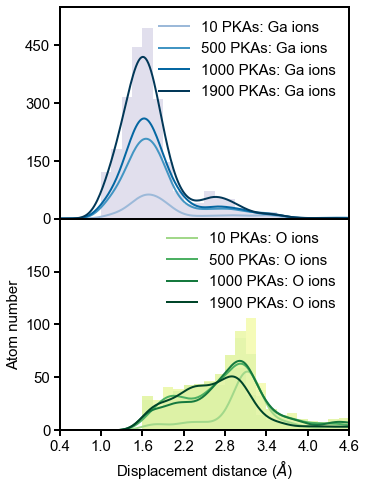

In [539]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
fig, axs = plt.subplots(2, 1,figsize=(4.1,6),sharex=True)
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0, hspace=0)
bin_edges = np.linspace(1, 4,21)
print(bin_edges)
t = np.linspace(0.4, 4.6, 210) 
pkal=[10,500,1000,1900]
cmap = plt.get_cmap('PuBu')
n_ga_peak=np.zeros(4)
n_o_peak=np.zeros(4)
ga_peak=np.zeros(4)
o_peak=np.zeros(4)
print('----Ga-----')

for j in range(4):
    i=pkal[j]
    c= cmap((j+2)/5)
    fn='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_anneal/anneal_dumpfile/1000_100ps_{}/particle_Displacement_Magnitude11.csv'.format(i)
    df=pd.read_csv(fn)
    dfGa = df[(df['Particle Type'] < 3) & (df['Displacement Magnitude'] > 1)]
    dfO = df[(df['Particle Type'] >2) & (df['Displacement Magnitude'] > 1.6)] 

    d=dfGa['Displacement Magnitude']
 #   d=dfO['Displacement Magnitude']
    print(d.mean(),d.std())
    hist1, bin_edge, patches=axs[0].hist(d, bins=bin_edges,alpha=1,histtype='bar',color=cmap((j+4)/40))
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]
    #print(i,hist1 )
    fit_y= kernel_density(t, d, 0.15)*ex
    axs[0].plot(t,fit_y, label='{} PKAs: Ga ions'.format(i),linewidth=2,color=c)
    n_ga_peak[j]=max(fit_y)
    index=np.argmax(fit_y)
    ga_peak[j]=t[index]
axs[0].tick_params(axis='x', width=0,length=2)
axs[0].set_yticks([ 0,150 ,300,450])
axs[0].legend(fontsize=15,frameon=False)
axs[0].tick_params(axis='y', width=2,length=6, labelsize=15)
axs[0].set_ylim(0, 550)
print('----O-----')
bin_edges = np.linspace(1.6, 4.6,21)
cmap2 = plt.get_cmap('YlGn')
for j in range(4):
    i=pkal[j]
    c2= cmap2((j+2)/5)
    fn='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_anneal/anneal_dumpfile/1000_100ps_{}/particle_Displacement_Magnitude11.csv'.format(i)
    df=pd.read_csv(fn)
    dfO = df[(df['Particle Type'] >2) & (df['Displacement Magnitude'] > 1.6)]     
    #d=dfGa['Displacement Magnitude']
    d=dfO['Displacement Magnitude']
    print(d.mean(),d.std())
    hist1, bin_edge, patches=axs[1].hist(d, bins=bin_edges,alpha=1,histtype='bar',color=cmap2((j+4)/30))
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]
    #print(i,hist1)
    fit_y= kernel_density(t, d, 0.15)*ex
    axs[1].plot(t,fit_y, label='{} PKAs: O ions'.format(i),linewidth=2,color=c2)
    n_o_peak[j]=max(fit_y)
    index=np.argmax(fit_y)
    o_peak[j]=t[index]
axs[1].set_xlabel('Displacement distance ($\AA$)',fontsize=15)
axs[1].set_ylabel('Atom number',fontsize=15)
axs[1].legend(fontsize=15,frameon=False)
axs[1].grid(False)
# Set the desired x-axis limits
axs[1].set_xticks([0.4,1.0,1.6,2.2,2.8,3.4,4,4.6])
axs[1].set_yticks([0,50,100,150])
axs[1].set_ylim(0, 200)
axs[1].set_xlim(0.4, 4.6)# Replace x_min and x_max with your desired range
axs[1].tick_params(axis='x', width=2,length=6,labelsize=15)
axs[1].tick_params(axis='y', width=2,length=6,labelsize=15)
#plt.savefig('my_plot.png')

----Ga-----
[ 4.87127746 14.40377784 17.24751825 30.75411996] [2.91196172 2.73110048 2.71100478 2.6708134 ]


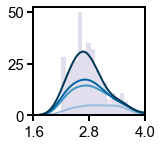

In [540]:
# Modify a global rcParam
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = (2,2) 
#find second peak of Ga ions
n_ga_peak2=np.zeros(4)
ga_peak2=np.zeros(4)
bin_edges = np.linspace(2.2, 4.0,21)
print('----Ga-----')

for j in range(4):
    i=pkal[j]
    c= cmap((j+2)/5)
    fn='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_anneal/anneal_dumpfile/1000_100ps_{}/particle_Displacement_Magnitude11.csv'.format(i)
    df=pd.read_csv(fn)
    dfGa = df[(df['Particle Type'] < 3) & (df['Displacement Magnitude'] > 2.2)]
    d=dfGa['Displacement Magnitude']
 #   d=dfO['Displacement Magnitude']
    hist1, bin_edge, patches=plt.hist(d, bins=bin_edges,alpha=1,histtype='bar',color=cmap((j+4)/40))
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]
    #print(i,hist1 )
    fit_y= kernel_density(t, d, 0.2)*ex
    n_ga_peak2[j]=max(fit_y)
    index=np.argmax(fit_y)
    ga_peak2[j]=t[index]
    plt.plot(t,fit_y, label='{} PKAs: Ga ions'.format(i),linewidth=2,color=c)
print(n_ga_peak2,ga_peak2)
plt.xticks([1.6,2.8,4])
plt.yticks([0,25,50])
plt.xlim(1.6, 4)
plt.tick_params(axis='x', width=2,length=6,labelsize=15)
plt.tick_params(axis='y', width=2,length=6,labelsize=15)

[ 62.58498096 207.49134647 260.31707035 420.3133663 ] [1.6861244  1.64593301 1.62583732 1.60574163]
[55.50435755 62.93086188 65.61991694 50.93222748] [3.13301435 3.03253589 3.01244019 2.89186603]
3.0174641148325354 1.6409090909090909 2.7562200956937795


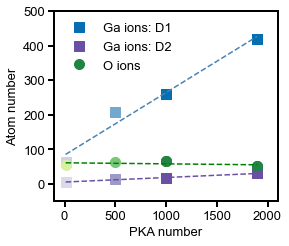

In [535]:
# Modify a global rcParam
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = (4,3.5) 

print(n_ga_peak,ga_peak)
print(n_o_peak,o_peak)
# Determine the number of colors you want
num_colors =4
cmap3 = plt.get_cmap('Purples')
# Create an array of colors using the colormap
colors = [cmap((i+1) / num_colors) for i in range(num_colors)]
colors2 = [cmap2((i+1) / num_colors) for i in range(num_colors)]
colors3 = [cmap3((i+1) / num_colors) for i in range(num_colors)]
for i in range(num_colors - 1):
    plt.plot(pkal[i:i+3], n_ga_peak[i:i+3],marker="s",linestyle='', color=colors[i],markersize=10)
    plt.plot(pkal[i:i+3], n_ga_peak2[i:i+3],marker="s",linestyle='', color=colors3[i],markersize=10)
    plt.plot(pkal[i:i+3], n_o_peak[i:i+3],marker="o",linestyle='', color=colors2[i],markersize=10)
       
plt.plot(pkal[i:i+3], n_ga_peak[i:i+3],marker="s",linestyle='', color=colors[i],markersize=10,label='Ga ions: D1')
plt.plot(pkal[i:i+3], n_ga_peak2[i:i+3],marker="s",linestyle='', color=colors3[i],markersize=10,label='Ga ions: D2')
plt.plot(pkal[i:i+3], n_o_peak[i:i+3],marker="o",linestyle='', color=colors2[i],markersize=10,label='O ions')   

#plt.plot(pkal,n_ga_peak,'s',markersize=10,color='steelblue',label='Ga1 ions')
x_fit,y_fit = linear_fit(pkal,n_ga_peak)
plt.plot(x_fit,y_fit,'--',color='steelblue')
#plt.plot(pkal,n_ga_peak2,'s',markersize=10,color='steelblue',label='Ga2 ions',markerfacecolor='white')
x_fit,y_fit = linear_fit(pkal,n_ga_peak2)
plt.plot(x_fit,y_fit,'--',color=colors3[i])
#plt.plot(pkal,n_o_peak,'o',markersize=10,color='green',label='O ions')
x_fit,y_fit = linear_fit(pkal,n_o_peak)
plt.plot(x_fit,y_fit,'--',color='green')
plt.xlim(-100, 2100)
plt.xticks([0,500,1000,1500,2000])
plt.yticks([0,100,200,300,400,500])
plt.ylim(-50, 500)
plt.tick_params(axis='x', width=2,length=6,labelsize=13)
plt.tick_params(axis='y', width=2,length=6,labelsize=13)
plt.xlabel('PKA number',fontsize=13)
plt.ylabel('Atom number',fontsize=13)
plt.legend(fontsize=13,frameon=False)


print(np.mean(o_peak),np.mean(ga_peak),np.mean(ga_peak2))

(1.0, 500.0)

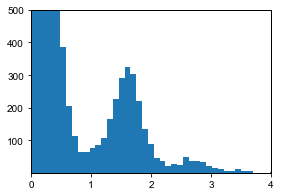

In [232]:
fn='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_anneal/anneal_dumpfile/1000_100ps_{}/particle_Displacement_Magnitude11.csv'.format(1900)
df=pd.read_csv(fn)
dfGa = df[(df['Particle Type'] < 3)]
d=dfGa['Displacement Magnitude']

plt.hist(d, bins=50,histtype='bar')
plt.xlim(0, 4)
plt.ylim(1, 500)

,Unnamed: 0,Particle Type,Particle Identifier,Displacement Magnitude
1,1,3,60600,0.253467
2,2,4,71535,0.153347
3,3,4,59990,0.165823
5,5,3,60579,0.200420
7,7,4,27936,0.280972
...,...,...,...,...
81912,81912,5,49617,0.064192
81913,81913,3,39099,0.144880
81914,81914,5,49072,0.411189
81916,81916,3,59280,0.487490


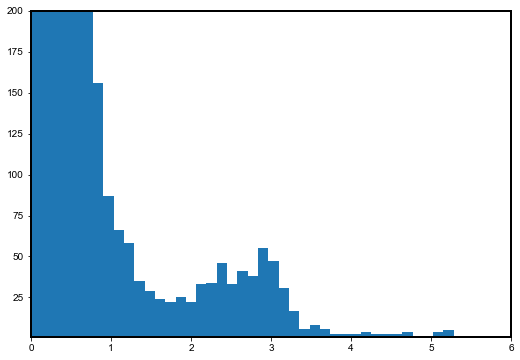

In [204]:
dfO = df[(df['Particle Type'] >2)]     
d=dfO['Displacement Magnitude']
plt.hist(d, bins=100,histtype='bar')
plt.xlim(0, 6)
plt.ylim(1, 200)
dfO

(array([  0., 100., 200., 300., 400., 500., 600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

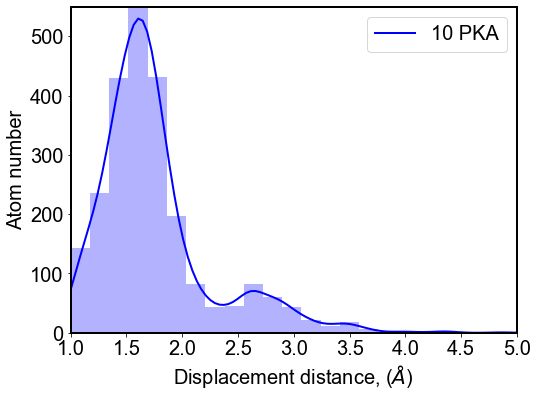

In [355]:
bin_edges = np.linspace(1, 6,30)
t = np.linspace(1, 5, 100) 
colors = ["blue","red",  "orange", "green", "orange", "yellow", "black"]
pkal=[10]
for j in range(1):
    i=pkal[j]
    c=colors[j]
    fn='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/cascade_anneal/anneal_dumpfile/1000_100ps_{}/particle_Displacement_Magnitude11.csv'.format(1900)
    df=pd.read_csv(fn)
    dfGa = df[(df['Particle Type'] < 3) & (df['Displacement Magnitude'] > 1)]
    dfO = df[(df['Particle Type'] >2) & (df['Displacement Magnitude'] > 1.6)]     
    
    d=dfGa['Displacement Magnitude']
    #d=dfO['Displacement Magnitude']
   
    hist1, bin_edge, patches=plt.hist(d, bins=bin_edges,alpha=0.3,histtype='bar',color=c)
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]

    plt.plot(t, kernel_density(t, d, 0.1)*ex, label='{} PKA'.format(i),linewidth=2,color=c)
plt.xlabel('Displacement distance, ($\AA$)',fontsize=20)
plt.ylabel('Atom number',fontsize=20)
plt.legend(fontsize=20)
plt.rcParams["font.family"] = "arial"
plt.grid(False)
# Set the desired x-axis limits
plt.xlim(1, 5)
plt.ylim(0, 550)# Replace x_min and x_max with your desired range
plt.rcParams["axes.linewidth"] = 2 
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["figure.figsize"] = (8,6) 
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 

[1.   1.15 1.3  1.45 1.6  1.75 1.9  2.05 2.2  2.35 2.5  2.65 2.8  2.95
 3.1  3.25 3.4  3.55 3.7  3.85 4.  ]
----Ga-----
2.3616247266246364 0.8867822669009559
2.314918086050099 0.9251905166290292
2.185751273294749 0.8080330356431824
2.154388389946313 0.7291042408730591
2.101834274606362 0.7864921723667292
2.056266416508496 0.6090740894888156
2.086181609341668 0.69113850677413
2.0933706458095243 0.721386332119886
2.126581967960717 0.6781948454273347
2.138251830579256 0.7396468563064175
2.1271765888400114 0.6900682405120135
2.137207980046809 0.6790071396767958
2.2312535394836255 0.7771742761298637
2.0210874115521213 0.628802697021002
2.0615426551624707 0.7252322770517774
2.048194636529004 0.7663381319101958
2.0540138118975513 0.7105686767436917
2.120940291967277 0.7616044415987767
1.9821291499612639 0.6445756365063753
----O-----
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


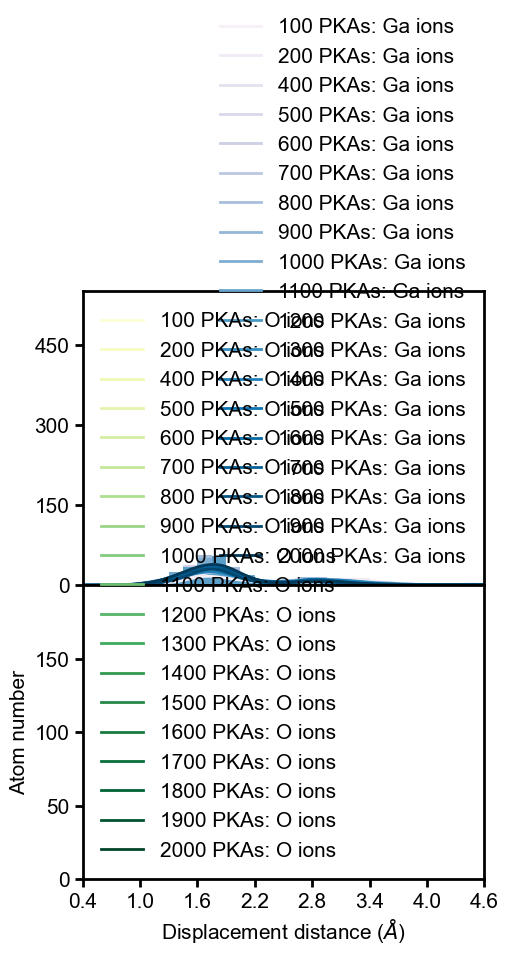

In [6]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
fig, axs = plt.subplots(2, 1,figsize=(4.1,6),sharex=True)
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0, hspace=0)
bin_edges = np.linspace(1, 4,21)
print(bin_edges)
t = np.linspace(0.4, 4.6, 210) 

pkal=[100, 200, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
cmap = plt.get_cmap('PuBu')
n_ga_peak=np.zeros(len(pkal))
n_o_peak=np.zeros(len(pkal))
ga_peak=np.zeros(len(pkal))
o_peak=np.zeros(len(pkal))
print('----Ga-----')

for j in range(len(pkal)):
    i=pkal[j]
    c= cmap((j+1)/len(pkal))
    fn='/Users/ruhe/Desktop/ga2o3/FP/tabGap/Ga/anneal_1000k_2ns/1000_2ns_{}/particle_Displacement_Magnitude.csv'.format(i)
    df=pd.read_csv(fn)
    dfGa = df[(df['Particle Type'] < 3) & (df['Displacement Magnitude'] > 1)]
    dfO = df[(df['Particle Type'] >2) & (df['Displacement Magnitude'] > 1.6)] 

    d=dfGa['Displacement Magnitude']
 #   d=dfO['Displacement Magnitude']
    print(d.mean(),d.std())
    hist1, bin_edge, patches=axs[0].hist(d, bins=bin_edges,alpha=1,histtype='bar',color=cmap((j+4)/40))
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]
    #print(i,hist1 )
    fit_y= kernel_density(t, d, 0.15)*ex
    axs[0].plot(t,fit_y, label='{} PKAs: Ga ions'.format(i),linewidth=2,color=c)
    n_ga_peak[j]=max(fit_y)
    index=np.argmax(fit_y)
    ga_peak[j]=t[index]
axs[0].tick_params(axis='x', width=0,length=2)
axs[0].set_yticks([ 0,150 ,300,450])
axs[0].legend(fontsize=15,frameon=False)
axs[0].tick_params(axis='y', width=2,length=6, labelsize=15)
axs[0].set_ylim(0, 550)
print('----O-----')
bin_edges = np.linspace(1.6, 4.6,21)
cmap2 = plt.get_cmap('YlGn')
for j in range(len(pkal)):
    i=pkal[j]
    c2= cmap2((j+1)/len(pkal))
    fn='/Users/ruhe/Desktop/ga2o3/FP/tabGap/Ga/anneal_1000k_2ns/1000_2ns_{}/particle_Displacement_Magnitude.csv'.format(i)
    df=pd.read_csv(fn)
    dfO = df[(df['Particle Type'] >2) & (df['Displacement Magnitude'] > 1.6)]     
    #d=dfGa['Displacement Magnitude']
    d=dfO['Displacement Magnitude']
    print(d.mean(),d.std())
    hist1, bin_edge, patches=axs[1].hist(d, bins=bin_edges,alpha=1,histtype='bar',color=cmap2((j+4)/30))
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]
    #print(i,hist1)
    fit_y= kernel_density(t, d, 0.15)*ex
    axs[1].plot(t,fit_y, label='{} PKAs: O ions'.format(i),linewidth=2,color=c2)
    n_o_peak[j]=max(fit_y)
    index=np.argmax(fit_y)
    o_peak[j]=t[index]
axs[1].set_xlabel('Displacement distance ($\AA$)',fontsize=15)
axs[1].set_ylabel('Atom number',fontsize=15)
axs[1].legend(fontsize=15,frameon=False)
axs[1].grid(False)
# Set the desired x-axis limits
axs[1].set_xticks([0.4,1.0,1.6,2.2,2.8,3.4,4,4.6])
axs[1].set_yticks([0,50,100,150])
axs[1].set_ylim(0, 200)
axs[1].set_xlim(0.4, 4.6)# Replace x_min and x_max with your desired range
axs[1].tick_params(axis='x', width=2,length=6,labelsize=15)
axs[1].tick_params(axis='y', width=2,length=6,labelsize=15)
#plt.savefig('my_plot.png')

----Ga-----
[4.60916194 4.55102771 4.0964009  5.80415914 3.13374028 5.39450901
 5.61887694        nan 5.62455621 5.82286782 5.5493314  6.78618322
 5.24064236 3.39992093 5.48592119 3.72312929 4.05999973 3.46665691
 4.36396967] [3.2937799  3.13301435 2.89186603 2.79138756 2.87177033 2.87177033
 2.73110048 0.4        2.85167464 2.77129187 2.87177033 2.91196172
 2.9923445  2.73110048 2.83157895 2.71100478 2.87177033 2.83157895
 2.89186603]


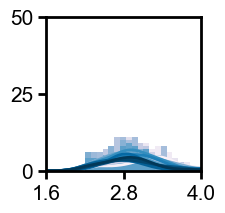

In [8]:
# Modify a global rcParam
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = (2,2) 
#find second peak of Ga ions
n_ga_peak2=np.zeros(len(pkal))
ga_peak2=np.zeros(len(pkal))
bin_edges = np.linspace(2.2, 4.0,21)
print('----Ga-----')

for j in range(len(pkal)):
    i=pkal[j]
    c= cmap((j+1)/len(pkal))
    fn='/Users/ruhe/Desktop/ga2o3/FP/tabGap/Ga/anneal_1000k_2ns/1000_2ns_{}/particle_Displacement_Magnitude.csv'.format(i)    
    df=pd.read_csv(fn)
    dfGa = df[(df['Particle Type'] < 3) & (df['Displacement Magnitude'] > 2.2)]
    d=dfGa['Displacement Magnitude']
 #   d=dfO['Displacement Magnitude']
    hist1, bin_edge, patches=plt.hist(d, bins=bin_edges,alpha=1,histtype='bar',color=cmap((j+4)/40))
    hist2, bin_edge = np.histogram(d, bins=bin_edges, density=True)
    ex=hist1[0]/hist2[0]
    #print(i,hist1 )
    fit_y= kernel_density(t, d, 0.2)*ex
    n_ga_peak2[j]=max(fit_y)
    index=np.argmax(fit_y)
    ga_peak2[j]=t[index]
    plt.plot(t,fit_y, label='{} PKAs: Ga ions'.format(i),linewidth=2,color=c)
print(n_ga_peak2,ga_peak2)
plt.xticks([1.6,2.8,4])
plt.yticks([0,25,50])
plt.xlim(1.6, 4)
plt.tick_params(axis='x', width=2,length=6,labelsize=15)
plt.tick_params(axis='y', width=2,length=6,labelsize=15)

[16.77488783 24.68365883 32.02297859 25.89707205         nan 31.84710034
 30.03066307 33.37424386 38.40043905         nan 32.08938532         nan
 24.87583004 32.49339245 35.07871018 36.95141337 30.79375398 30.05020194
 38.99253979] [1.7062201  1.78660287 1.76650718 1.78660287 0.4        1.74641148
 1.62583732 1.76650718 1.74641148 0.4        1.76650718 0.4
 1.74641148 1.76650718 1.72631579 1.74641148 1.78660287 1.74641148
 1.76650718]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan] [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
 0.4]
0.4000000000000001 1.5359355326114328 2.750138504155124


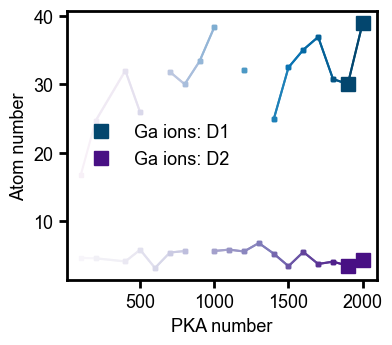

In [14]:
# Modify a global rcParam
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = (4,3.5) 

print(n_ga_peak,ga_peak)
print(n_o_peak,o_peak)
# Determine the number of colors you want
num_colors =len(pkal)
cmap3 = plt.get_cmap('Purples')

plt.plot(pkal, n_ga_peak,marker="s",linestyle='-',markersize=3)
plt.plot(pkal, n_ga_peak2,marker="s",linestyle='-',markersize=3)

#plt.plot(pkal,n_ga_peak,'s',markersize=10,color='steelblue',label='Ga1 ions')
x_fit,y_fit = linear_fit(pkal,n_ga_peak)
plt.plot(x_fit,y_fit,'--',color='steelblue')
#plt.plot(pkal,n_ga_peak2,'s',markersize=10,color='steelblue',label='Ga2 ions',markerfacecolor='white')
x_fit,y_fit = linear_fit(pkal,n_ga_peak2)
plt.plot(x_fit,y_fit,'--',color=colors3[i])
#plt.plot(pkal,n_o_peak,'o',markersize=10,color='green',label='O ions')
#x_fit,y_fit = linear_fit(pkal,n_o_peak)
#plt.plot(x_fit,y_fit,'--',color='green')
#plt.xlim(-100, 2100)
#plt.xticks([0,500,1000,1500,2000])
#plt.yticks([0,100,200,300,400,500])
#plt.ylim(-50, 500)
plt.tick_params(axis='x', width=2,length=6,labelsize=13)
plt.tick_params(axis='y', width=2,length=6,labelsize=13)
plt.xlabel('PKA number',fontsize=13)
plt.ylabel('Atom number',fontsize=13)
plt.legend(fontsize=13,frameon=False)


print(np.mean(o_peak),np.mean(ga_peak),np.mean(ga_peak2))